# SVDiff-pytorch
<a href="https://colab.research.google.com/github/mkshing/svdiff-pytorch/blob/main/scripts/svdiff_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an implementation of [SVDiff: Compact Parameter Space for Diffusion Fine-Tuning](https://arxiv.org/abs/2303.11305) by using d🧨ffusers. 

- My summary tweet: https://twitter.com/mk1stats/status/1642865505106272257
- Code: https://github.com/mkshing/svdiff-pytorch


## **Setup**

In [ ]:
!nvidia-smi
!git clone https://mkshing@github.com/mkshing/svdiff-pytorch.git
!pip install -r svdiff-pytorch/requirements.txt
!pip install -q -U --pre triton
!pip install -q ftfy bitsandbytes==0.35.0 gradio natsort xformers

In [ ]:
# @markdown **(Optional) Login wandb**<br> If you don't use wandb for logging, make sure to remove `--report_to="wandb"`
!wandb login

## **Training SVDiff**

In this example, use 5 dog images as usual by downloading from [here](https://drive.google.com/drive/folders/1BO_dyz-p65qhBRRMRA4TbZ8qW4rB99JZ).

In [ ]:
#@title **Dataset**
import datetime
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


def display_pic(folder):
    fig = plt.figure(figsize=(30, 60))
    files = sorted(glob.glob(folder+'/*.jpg'))
    for i, file in enumerate(files):
        img = Image.open(file)    
        images = np.asarray(img)
        ax = fig.add_subplot(10, 5, i+1, xticks=[], yticks=[])
        image_plt = np.array(images)
        ax.imshow(image_plt)
        name = os.path.basename(file)
        ax.set_xlabel(name, fontsize=30)  
        fig.tight_layout()             
    plt.show()
    plt.close()


# save_image = True #@param {type:"boolean"}
mount_google_drive = True #@param {type:"boolean"}
INSTANCE_DATA_DIR = "/content/drive/MyDrive/AI/dreambooth-dog/data" #@param {type: 'string'}
CLASS_DATA_DIR = "/content/drive/MyDrive/AI/dreambooth-dog/class-data" #@param {type: 'string'}
OUTPUT_DIR = "/content/SVDiffOutput" #@param {type: 'string'}

if CLASS_DATA_DIR is None:
  CLASS_DATA_DIR = OUTPUT_DIR + "/class_data_dir"

force_remount = False
if mount_google_drive:
    from google.colab import drive # type: ignore
    try:
        drive_path = "/content/drive"
        drive.mount(drive_path, force_remount=force_remount)
        # output_path_gdrive = f"/content/drive/MyDrive/{save_dir}"
        # save_dir = output_path_gdrive
    except:
        print("...error mounting drive or with drive path variables")
        print("...reverting to default path variables")
OUTPUT_DIR = os.path.abspath(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"INSTANCE_DATA_DIR: {INSTANCE_DATA_DIR}")
print(f"CLASS_DATA_DIR: {CLASS_DATA_DIR}")
print(f"OUTPUT_DIR: {OUTPUT_DIR}")


In [ ]:
# @title **Parameters:**
MODEL_NAME = "runwayml/stable-diffusion-v1-5" # @param {type: "string"}
# this is the number nitrosoke recommends 
NUM_CLASS_IMAGES = 200 #@param {type: "integer"}
MAX_TRAIN_STEPS = 500 #@param {type: "integer"}
CHECKPOINTING_STEPS = 200 #@param {type: "integer"}

In [ ]:
from accelerate.utils import write_basic_config
write_basic_config()

PosixPath('/root/.cache/huggingface/accelerate/default_config.yaml')

In [ ]:
# @title **Train:**
! accelerate launch svdiff-pytorch/train_svdiff.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DATA_DIR \
  --class_data_dir=$CLASS_DATA_DIR \
  --output_dir=$OUTPUT_DIR \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --instance_prompt="photo of a sks dog" \
  --class_prompt="photo of a dog" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-3 \
  --learning_rate_1d=1e-6 \
  --train_text_encoder \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=$NUM_CLASS_IMAGES \
  --checkpointing_steps=$CHECKPOINTING_STEPS \
  --max_train_steps=$MAX_TRAIN_STEPS \
  --use_8bit_adam \
  --seed=42 \
  --enable_xformers_memory_efficient_attention \
  --gradient_checkpointing \
  # --report_to="wandb" \
  # --revision="fp16" \
  # --mixed_precision="fp16" \



### **Inference:**

In [ ]:
#@markdown **helper functions**
import os
import sys
import io
import requests
import PIL
import torch
from torch import autocast
import huggingface_hub
from transformers import CLIPTextModel
from diffusers import (
    LMSDiscreteScheduler, 
    DDIMScheduler, 
    PNDMScheduler,
    DPMSolverMultistepScheduler, 
    EulerDiscreteScheduler, 
    EulerAncestralDiscreteScheduler,
    StableDiffusionPipeline
)
from PIL import Image
sys.path.append("/content/svdiff-pytorch")
from svdiff_pytorch import load_unet_for_svdiff, load_text_encoder_for_svdiff, SCHEDULER_MAPPING, image_grid


def load_text_encoder(pretrained_model_name_or_path, spectral_shifts_ckpt, device, fp16=False):
    if os.path.isdir(spectral_shifts_ckpt):
        spectral_shifts_ckpt = os.path.join(spectral_shifts_ckpt, "spectral_shifts_te.safetensors")
    elif not os.path.exists(spectral_shifts_ckpt):
        # download from hub
        hf_hub_kwargs = {} if hf_hub_kwargs is None else hf_hub_kwargs
        try:
            spectral_shifts_ckpt = huggingface_hub.hf_hub_download(spectral_shifts_ckpt, filename="spectral_shifts_te.safetensors", **hf_hub_kwargs)
        except huggingface_hub.utils.EntryNotFoundError:
            return CLIPTextModel.from_pretrained(pretrained_model_name_or_path, subfolder="text_encoder", torch_dtype=torch.float16 if fp16 else None).to(device)
    if not os.path.exists(spectral_shifts_ckpt):
            return CLIPTextModel.from_pretrained(pretrained_model_name_or_path, subfolder="text_encoder", torch_dtype=torch.float16 if fp16 else None).to(device)
    text_encoder = load_text_encoder_for_svdiff(
        pretrained_model_name_or_path=pretrained_model_name_or_path,
        spectral_shifts_ckpt=spectral_shifts_ckpt,
        subfolder="text_encoder", 
    )
    # first perform svd and cache
    for module in text_encoder.modules():
        if hasattr(module, "perform_svd"):
            module.perform_svd()
    if fp16:
        text_encoder = text_encoder.to(device, dtype=torch.float16)
    return text_encoder


In [ ]:
# @markdown **Load model:**
import sys
from diffusers import AutoencoderKL

spectral_shifts_ckpt = "/content/SVDiffOutput" #@param {type:"string"}
scheduler_type = "dpm_solver++" #@param ["ddim", "plms", "lms", "euler", "euler_ancestral", "dpm_solver++"]

device = "cuda" if torch.cuda.is_available() else "cpu"
unet = load_unet_for_svdiff(MODEL_NAME, spectral_shifts_ckpt=spectral_shifts_ckpt, subfolder="unet")
unet = unet.to(device)
for module in unet.modules():
  if hasattr(module, "perform_svd"):
    module.perform_svd()

unet = unet.to(device, dtype=torch.float16)
text_encoder = load_text_encoder(
    pretrained_model_name_or_path=MODEL_NAME, 
    spectral_shifts_ckpt=spectral_shifts_ckpt, 
    device=device,
    fp16=True,
)
# load pipe
pipe = StableDiffusionPipeline.from_pretrained(
    MODEL_NAME,
    unet=unet,
    text_encoder=text_encoder,
    vae=AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse"),
    requires_safety_checker=False,
    safety_checker=None,
    feature_extractor=None,
    scheduler=SCHEDULER_MAPPING[scheduler_type].from_pretrained(MODEL_NAME, subfolder="scheduler"),
    torch_dtype=torch.float16
)

pipe = pipe.to(device)
print("loaded pipeline")

seed: 390691425


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:12<00:00, 12.08s/it]


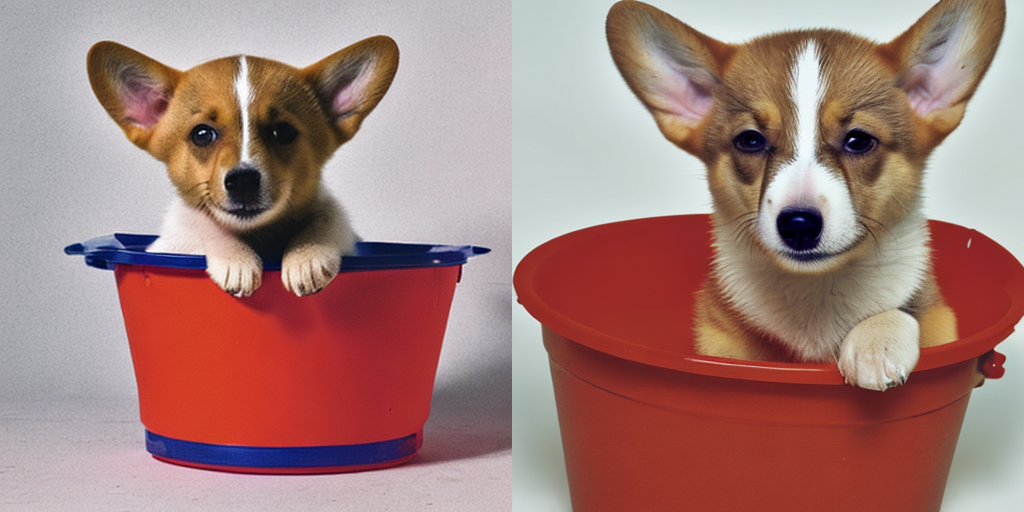

In [ ]:
# @markdown **Run!:**
# @markdown <br> *It takes time at the 1st run because SVD is performed. 
import random
from tqdm import tqdm

prompt = "A picture of a sks dog in a bucket" #@param {type:"string"}
num_images_per_prompt = 2 # @param {type: "integer"}
guidance_scale = 7.5 # @param {type: "number"}
num_inference_steps = 25 # @param {type: "integer"}
height = 512 # @param {type: "integer"}
width = 512 # @param {type: "integer"}
seed = "random_seed" #@param {type:"string"}
spectral_shifts_scale = 1.0 #@param {type: "number"}


if pipe.unet.conv_out.scale != spectral_shifts_scale:
  for module in pipe.unet.modules():
    if hasattr(module, "set_scale"):
      module.set_scale(scale=spectral_shifts_scale)
  for module in pipe.text_encoder.modules():
    if hasattr(module, "set_scale"):
      module.set_scale(scale=spectral_shifts_scale)     
  print(f"Set spectral_shifts_scale to {spectral_shifts_scale}!")
  

if seed == "random_seed":
  random.seed()
  seed = random.randint(0, 2**32)
else:
  seed = int(seed)
g_cuda = torch.Generator(device='cuda').manual_seed(seed)
print(f"seed: {seed}")

prompts = prompt.split("::")
all_images = []
for prompt in tqdm(prompts):
    with torch.autocast(device), torch.inference_mode():
        images = pipe(
            prompt,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            num_images_per_prompt=num_images_per_prompt,
            height=height,
            width=width,
            generator=g_cuda
        ).images
    all_images.extend(images)
grid_image = image_grid(all_images, len(prompts), num_images_per_prompt)
grid_image

### **(Optional) Upload HuggingFace Hub**

In [ ]:
# @markdown login huggingface hub
from huggingface_hub import login
login()

In [ ]:
from huggingface_hub import create_repo, upload_folder


hub_model_id = "svdiff-library/svdiff_dog_example" #@param {type: "string"}
hub_token = "" #@param {type: "string"}
folder_path = "/content/SVDiffOutput" #@param {type: "string"}

if hub_token == "":
  hub_token = None
repo_id = create_repo(repo_id=hub_model_id, exist_ok=True, token=hub_token).repo_id

base_model = MODEL_NAME
instance_prompt = "photo of a sks dog"  #@param {type: "string"}
# @markdown paste your `instace_prompt` here.

yaml = f"""
---
license: creativeml-openrail-m
base_model: {base_model}
instance_prompt: {instance_prompt}
tags:
- stable-diffusion
- stable-diffusion-diffusers
- text-to-image
- diffusers
- svdiff
inference: true
---
"""
model_card = f"""
# SVDiff-pytorch - {repo_id}
These are SVDiff weights for {base_model}. The weights were trained on {instance_prompt} as Single-Subject Generation."""
with open(os.path.join(folder_path, "README.md"), "w") as f:
    f.write(yaml + model_card)

upload_folder(
    repo_id=repo_id,
    folder_path=folder_path,
    commit_message="first commit",
    ignore_patterns=["step_*", "epoch_*"],
)



'https://huggingface.co/svdiff-library/svdiff_dog_example/tree/main/'

## **Single Image Editing**


INSTANCE_DATA_DIR: /content/SIEOutput/data
CLASS_DATA_DIR: /content/drive/MyDrive/AI/dreambooth-dog/class-data
OUTPUT_DIR: /content/SIEOutput


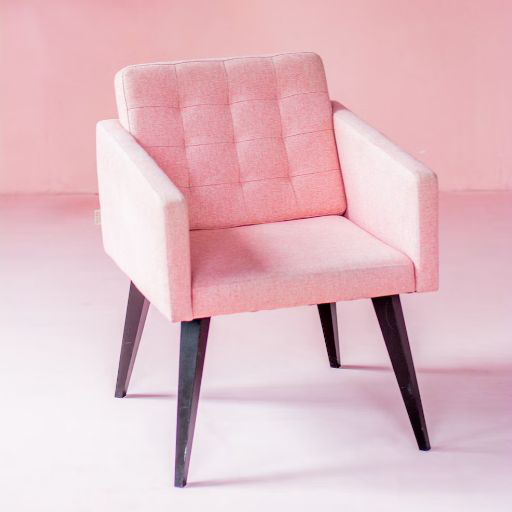

In [4]:
#@title **Dataset**
import datetime
import glob
import os
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


def display_pic(folder):
    fig = plt.figure(figsize=(30, 60))
    files = sorted(glob.glob(folder+'/*.jpg'))
    for i, file in enumerate(files):
        img = Image.open(file)    
        images = np.asarray(img)
        ax = fig.add_subplot(10, 5, i+1, xticks=[], yticks=[])
        image_plt = np.array(images)
        ax.imshow(image_plt)
        name = os.path.basename(file)
        ax.set_xlabel(name, fontsize=30)  
        fig.tight_layout()             
    plt.show()
    plt.close()


def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')



# save_image = True #@param {type:"boolean"}
mount_google_drive = False #@param {type:"boolean"}
# original url: https://unsplash.com/photos/1JJJIHh7-Mk
# croped image: https://drive.google.com/drive/folders/1rEd6cDxeCwmUBkiO_3ytUT2C6s92dTSK
image_path_or_url = "/content/pink-chair.jpeg" #@param {type: "string"}
image = Image.open(fetch(image_path_or_url)).convert("RGB").resize((512, 512))
CLASS_DATA_DIR = "/content/drive/MyDrive/AI/dreambooth-dog/class-data" #@param {type: 'string'}
OUTPUT_DIR = "/content/SIEOutput" #@param {type: 'string'}

if CLASS_DATA_DIR is None:
  CLASS_DATA_DIR = OUTPUT_DIR + "/class_data_dir"

force_remount = False
if mount_google_drive:
    from google.colab import drive # type: ignore
    try:
        drive_path = "/content/drive"
        drive.mount(drive_path, force_remount=force_remount)
        # output_path_gdrive = f"/content/drive/MyDrive/{save_dir}"
        # save_dir = output_path_gdrive
    except:
        print("...error mounting drive or with drive path variables")
        print("...reverting to default path variables")
OUTPUT_DIR = os.path.abspath(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# save image to output_dir
INSTANCE_DATA_DIR = os.path.join(OUTPUT_DIR, "data")
os.makedirs(INSTANCE_DATA_DIR, exist_ok=True)
image.save(os.path.join(INSTANCE_DATA_DIR, "image.png"))

print(f"INSTANCE_DATA_DIR: {INSTANCE_DATA_DIR}")
print(f"CLASS_DATA_DIR: {CLASS_DATA_DIR}")
print(f"OUTPUT_DIR: {OUTPUT_DIR}")
image

In [8]:
# @title **Parameters:**
MODEL_NAME = "runwayml/stable-diffusion-v1-5" # @param {type: "string"}
# this is the number nitrosoke recommends 
NUM_CLASS_IMAGES = 200 #@param {type: "integer"}
MAX_TRAIN_STEPS = 500 #@param {type: "integer"}
CHECKPOINTING_STEPS = 200 #@param {type: "integer"}

In [ ]:
from accelerate.utils import write_basic_config
write_basic_config()

In [ ]:
# @title **Train:**
! accelerate launch svdiff-pytorch/train_svdiff.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DATA_DIR \
  --output_dir=$OUTPUT_DIR \
  --instance_prompt="photo of a pink chair with black legs" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --learning_rate=1e-3 \
  --learning_rate_1d=1e-6 \
  --train_text_encoder \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=200 \
  --max_train_steps=500 \
  --use_8bit_adam \
  --enable_xformers_memory_efficient_attention \
  --seed=42 \
  --gradient_checkpointing \
  # --class_data_dir=$CLASS_DIR \
  # --with_prior_preservation --prior_loss_weight=1.0 \
  # --class_prompt="photo of a chair" \

### **Inference:**

In [10]:
#@markdown **helper functions**
import os
import sys
import io
import requests
import PIL
import torch
from torch import autocast
import huggingface_hub
from transformers import CLIPTextModel
from PIL import Image
sys.path.append("/content/svdiff-pytorch")
from svdiff_pytorch import load_unet_for_svdiff, load_text_encoder_for_svdiff, image_grid, StableDiffusionPipelineWithDDIMInversion


def load_text_encoder(pretrained_model_name_or_path, spectral_shifts_ckpt, device, fp16=False, hf_hub_kwargs=None,):
    if os.path.isdir(spectral_shifts_ckpt):
        spectral_shifts_ckpt = os.path.join(spectral_shifts_ckpt, "spectral_shifts_te.safetensors")
    elif not os.path.exists(spectral_shifts_ckpt):
        # download from hub
        hf_hub_kwargs = {} if hf_hub_kwargs is None else hf_hub_kwargs
        try:
            spectral_shifts_ckpt = huggingface_hub.hf_hub_download(spectral_shifts_ckpt, filename="spectral_shifts_te.safetensors", **hf_hub_kwargs)
        except huggingface_hub.utils.EntryNotFoundError:
            return CLIPTextModel.from_pretrained(pretrained_model_name_or_path, subfolder="text_encoder", torch_dtype=torch.float16 if fp16 else None).to(device)
    if not os.path.exists(spectral_shifts_ckpt):
            return CLIPTextModel.from_pretrained(pretrained_model_name_or_path, subfolder="text_encoder", torch_dtype=torch.float16 if fp16 else None).to(device)
    text_encoder = load_text_encoder_for_svdiff(
        pretrained_model_name_or_path=pretrained_model_name_or_path,
        spectral_shifts_ckpt=spectral_shifts_ckpt,
        subfolder="text_encoder", 
    )
    # first perform svd and cache
    for module in text_encoder.modules():
        if hasattr(module, "perform_svd"):
            module.perform_svd()
    if fp16:
        text_encoder = text_encoder.to(device, dtype=torch.float16)
    return text_encoder


In [14]:
# @markdown **Load model:**
import sys
from diffusers import AutoencoderKL, DDIMScheduler

spectral_shifts_ckpt = "svdiff-library/svdiff_chair_example" #@param {type:"string"}

device = "cuda" if torch.cuda.is_available() else "cpu"
unet = load_unet_for_svdiff(MODEL_NAME, spectral_shifts_ckpt=spectral_shifts_ckpt, subfolder="unet")
text_encoder = load_text_encoder(
    pretrained_model_name_or_path=MODEL_NAME, 
    spectral_shifts_ckpt=spectral_shifts_ckpt, 
    device=device,
)
# load pipe
pipe = StableDiffusionPipelineWithDDIMInversion.from_pretrained(
    MODEL_NAME,
    unet=unet,
    text_encoder=text_encoder,
    vae=AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse"),
    requires_safety_checker=False,
    safety_checker=None,
    feature_extractor=None,
)
# use ddim
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

pipe = pipe.to(device)
print("loaded pipeline")

/usr/local/lib/python3.9/dist-packages/safetensors/torch.py:99: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  with safe_open(filename, framework="pt", device=device) as f:
/usr/local/lib/python3.9/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/usr/local/lib/python3.9/dist-packages/torch/storage.py:899: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This shoul

Resumed from /root/.cache/huggingface/hub/models--svdiff-library--svdiff_chair_example/snapshots/16875cc346142bbc1c4b618e3b3da1e1d85ad7b7/spectral_shifts.safetensors


/content/svdiff-pytorch/svdiff_pytorch/utils.py:132: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  with safe_open(spectral_shifts_ckpt, framework="pt", device="cpu") as f:


Resumed from /root/.cache/huggingface/hub/models--svdiff-library--svdiff_chair_example/snapshots/16875cc346142bbc1c4b618e3b3da1e1d85ad7b7/spectral_shifts_te.safetensors


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

loaded pipeline


seed: 1625526040
DDIM Inversion...


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:09<00:00,  9.22s/it]


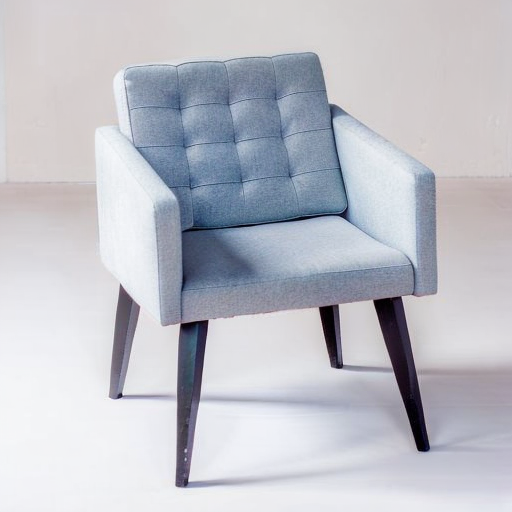

In [18]:
# @markdown **Run!:**
# @markdown <br> *It takes time at the 1st run because SVD is performed. 
import random
from tqdm import tqdm
import sys
import torch
from PIL import Image
from diffusers import DDIMScheduler

target_prompt = "photo of a blue chair with black legs" #@param {type: "string"}
#@markdown If you want to use DDIM inversion, please input your training prompt and image below.
# source_prompt = "photo of a pink chair with black legs" 
# source_prompt = "" #@param {type: "string"}
source_image_path_or_url = "/content/pink-chair.jpeg" #@param {type: "string"}
num_images_per_prompt = 1 # @param {type: "integer"}
guidance_scale = 5.0 # @param {type: "number"}
ddim_eta = 0.5 # @param {type: "number"}
num_inference_steps = 25 # @param {type: "integer"}
height = 512 # @param {type: "integer"}
width = 512 # @param {type: "integer"}
seed = "random_seed" #@param {type:"string"}
spectral_shifts_scale = 1.0 #@param {type: "number"}


if pipe.unet.conv_out.scale != spectral_shifts_scale:
  for module in pipe.unet.modules():
    if hasattr(module, "set_scale"):
      module.set_scale(scale=spectral_shifts_scale)
  print(f"Set spectral_shifts_scale to {spectral_shifts_scale}!")
  

if seed == "random_seed":
  random.seed()
  seed = random.randint(0, 2**32)
else:
  seed = int(seed)
g_cuda = torch.Generator(device='cuda').manual_seed(seed)
print(f"seed: {seed}")

inv_latents = None
# (optional) ddim inversion
if source_image_path_or_url != "":
  print("DDIM Inversion...")
  # if you don't do it, inv_latents = None
  image = Image.open(fetch(source_image_path_or_url)).convert("RGB").resize((width, height))
  # in SVDiff, they use guidance scale=1 in ddim inversion
  inv_latents = pipe.invert(target_prompt, image=image, guidance_scale=1.0).latents


target_prompt = target_prompt.split("::")
all_images = []
for prompt in tqdm(target_prompt):
    with torch.autocast(device), torch.inference_mode():
        images = pipe(
            prompt,
            latents=inv_latents,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            eta=ddim_eta,
            num_images_per_prompt=num_images_per_prompt,
            height=height,
            width=width,
            generator=g_cuda,
        ).images
    all_images.extend(images)
grid_image = image_grid(all_images, len(target_prompt), num_images_per_prompt)
grid_image


### **(Optional) Upload HuggingFace Hub**

In [6]:
# @markdown login huggingface hub
from huggingface_hub import login
login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
from huggingface_hub import create_repo, upload_folder


hub_model_id = "svdiff-library/svdiff_chair_example" #@param {type: "string"}
hub_token = "" #@param {type: "string"}
folder_path = "/content/SIEOutput" #@param {type: "string"}

if hub_token == "":
  hub_token = None
repo_id = create_repo(repo_id=hub_model_id, exist_ok=True, token=hub_token).repo_id

base_model = MODEL_NAME
instance_prompt = "photo of a pink chair with black legs"  #@param {type: "string"}
# @markdown paste your `instace_prompt` here.

yaml = f"""
---
license: creativeml-openrail-m
base_model: {base_model}
instance_prompt: {instance_prompt}
tags:
- stable-diffusion
- stable-diffusion-diffusers
- text-to-image
- diffusers
- svdiff
inference: true
---
"""
model_card = f"""
# SVDiff-pytorch - {repo_id}
These are SVDiff weights for {base_model}. The weights were trained on {instance_prompt} as Single Image Editing."""
with open(os.path.join(folder_path, "README.md"), "w") as f:
    f.write(yaml + model_card)

upload_folder(
    repo_id=repo_id,
    folder_path=folder_path,
    commit_message="first commit",
    ignore_patterns=["step_*", "epoch_*"],
)



## **(Optional) Compare with LoRA**

In LoRA, the number of trainable parameters is 0.80 M by default. 

In [ ]:
# @title **LoRA**
!accelerate launch svdiff-pytorch/scripts/train_dreambooth_lora.py \
  --pretrained_model_name_or_path="CompVis/stable-diffusion-v1-4" \
  --instance_data_dir="/content/drive/MyDrive/AI/dreambooth-dog/data" \
  --class_data_dir="/content/drive/MyDrive/AI/dreambooth-dog/class-data" \
  --output_dir="/content/LoRAOutput" \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --instance_prompt="photo of a sks dog" \
  --class_prompt="photo of a dog" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --checkpointing_steps=100 \
  --learning_rate=1e-4 \
  --report_to="wandb" \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=200 \
  --max_train_steps=500 \
  --mixed_precision="fp16" \
  --gradient_checkpointing \
  --seed 42 \
  --push_to_hub \
  --validation_prompt="A photo of sks dog in a bucket" \
  --validation_epochs=50 \
  --hub_model_id="mshing/lora_dreambooth_dog_example"

In [ ]:
# @title **Inference LoRA**
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
import torch

pipe = DiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

pipe.unet.load_attn_procs("/content/LoRAOutput")
image = pipe("A picture of a sks dog in a bucket", num_inference_steps=25).images[0]
del pipe
torch.cuda.empty_cache()
image